### Importing Necessary Libraries

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
# from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [2]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [3]:
labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15995,15995,./Data/train/train/15995.tif,2
15996,15996,./Data/train/train/15996.tif,15
15997,15997,./Data/train/train/15997.tif,3
15998,15998,./Data/train/train/15998.tif,9


In [4]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [5]:
train_labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15195,15995,./Data/train/train/15995.tif,2
15196,15996,./Data/train/train/15996.tif,15
15197,15997,./Data/train/train/15997.tif,3
15198,15998,./Data/train/train/15998.tif,9


In [6]:
test_labels

,id,images,label
0,18,./Data/train/train/18.tif,11
1,25,./Data/train/train/25.tif,8
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
...,...,...,...
795,15816,./Data/train/train/15816.tif,2
796,15824,./Data/train/train/15824.tif,2
797,15832,./Data/train/train/15832.tif,11
798,15863,./Data/train/train/15863.tif,15


In [7]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

## Data Preparation

We have already generated the Extracted Feature Vectors from the ResNet Model now we train using that, so we load those feature vectors.

In [10]:
FEATURE_DIM = 512

In [8]:
fine_tune_data = np.concatenate([np.transpose(np.load(f'./Data/VGG16-4P-train-precompute/train_data_precomp-{idx}.npy'), (1,0,2)) for idx in range(10)])
np.save(f'./Data/VGG16-4P-train-precompute/whole_train_data_precomp.npy', fine_tune_data)
fine_tune_data.shape

(16000, 5, 512)

In [9]:
fine_tune_data = np.load('./Data/VGG16-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data.shape

(16000, 5, 512)

In [11]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [12]:
fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
fine_tune_data_train.shape

(15200, 5, 512)

In [13]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [14]:
fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
fine_tune_data_test.shape

(800, 5, 512)

In [15]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

## Fine-Tuning Models

The fine-tuning part of our model.

In [44]:
def ftmodel():
    inputs = Input(shape=(5, FEATURE_DIM))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.5
    x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_3')(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model(inputs, outputs, name='VGG16-FineTune')
    return model1

In [45]:
model1 = ftmodel()
model1.summary()

Model: "VGG16-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 512)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                                 
 batch_normalization_2 (Batc  (None, 2560)             10240     
 hNormalization)                                                 
                                                                 
 top_dropout_1 (Dropout)     (None, 2560)              0         
                                                                 
 top_dense_1 (Dense)         (None, 1024)              2622464   
                                                                 
 batch_normalization_3 (Batc  (None, 1024)             4096      
 hNormalization)                                    

### Model Training

The fine-tuning will be done on the VGG16's $512D$ representation vectors.

In [46]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [47]:
EPOCHS = 1000
checkpoint_filepaths = ['./Models/VGG16-4P/auto-VGG16-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [48]:
history = model1.fit(fine_tune_data_train, fine_tune_labels_train, epochs=EPOCHS, batch_size=800, validation_data=(fine_tune_data_test, fine_tune_labels_test), validation_batch_size=800, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/VGG16-4P/effnet-4p-model-weights")
model1.load_weights('./Models/VGG16-4P/effnet-4p-model-weights')

Epoch 1/1000


2022-10-08 18:32:35.463674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/19 [======================>.......] - ETA: 0s - loss: 3.3046 - accuracy: 0.1812

2022-10-08 18:32:36.074789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 1s 35ms/step - loss: 3.1886 - accuracy: 0.2041 - val_loss: 3.0974 - val_accuracy: 0.2488
Epoch 2/1000
19/19 [==============================] - 0s 20ms/step - loss: 2.4367 - accuracy: 0.3711 - val_loss: 2.1864 - val_accuracy: 0.4100
Epoch 3/1000
19/19 [==============================] - 0s 19ms/step - loss: 2.1704 - accuracy: 0.4305 - val_loss: 1.8991 - val_accuracy: 0.4950
Epoch 4/1000
19/19 [==============================] - 0s 19ms/step - loss: 2.0147 - accuracy: 0.4684 - val_loss: 1.7287 - val_accuracy: 0.5450
Epoch 5/1000
19/19 [==============================] - 0s 21ms/step - loss: 1.9046 - accuracy: 0.4961 - val_loss: 1.6063 - val_accuracy: 0.5863
Epoch 6/1000
19/19 [==============================] - 0s 21ms/step - loss: 1.8246 - accuracy: 0.5186 - val_loss: 1.5249 - val_accuracy: 0.6137
Epoch 7/1000
19/19 [==============================] - 0s 20ms/step - loss: 1.7469 - accuracy: 0.5299 - val_loss: 1.4607 - val_accuracy: 0.6275
Epoch 8/1000

19/19 [==============================] - 0s 19ms/step - loss: 0.8699 - accuracy: 0.7716 - val_loss: 0.9955 - val_accuracy: 0.7587
Epoch 59/1000
19/19 [==============================] - 0s 21ms/step - loss: 0.8669 - accuracy: 0.7724 - val_loss: 1.0066 - val_accuracy: 0.7500
Epoch 60/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.8604 - accuracy: 0.7763 - val_loss: 0.9970 - val_accuracy: 0.7500
Epoch 61/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.8532 - accuracy: 0.7754 - val_loss: 0.9955 - val_accuracy: 0.7525
Epoch 62/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.8491 - accuracy: 0.7785 - val_loss: 1.0009 - val_accuracy: 0.7525
Epoch 63/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.8316 - accuracy: 0.7846 - val_loss: 0.9957 - val_accuracy: 0.7525
Epoch 64/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.8234 - accuracy: 0.7849 - val_loss: 0.9985 - val_accuracy: 0.7575
Epoch 

Epoch 115/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.5879 - accuracy: 0.8576 - val_loss: 1.0524 - val_accuracy: 0.7637
Epoch 116/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.5906 - accuracy: 0.8588 - val_loss: 1.0330 - val_accuracy: 0.7750
Epoch 117/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.5865 - accuracy: 0.8584 - val_loss: 1.0454 - val_accuracy: 0.7675
Epoch 118/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.5774 - accuracy: 0.8617 - val_loss: 1.0458 - val_accuracy: 0.7688
Epoch 119/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.5663 - accuracy: 0.8666 - val_loss: 1.0421 - val_accuracy: 0.7675
Epoch 120/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.5807 - accuracy: 0.8588 - val_loss: 1.0480 - val_accuracy: 0.7700
Epoch 121/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.5714 - accuracy: 0.8641 - val_loss: 1.0563 - val_ac

19/19 [==============================] - 0s 12ms/step - loss: 0.4309 - accuracy: 0.9078 - val_loss: 1.1008 - val_accuracy: 0.7812
Epoch 172/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.4216 - accuracy: 0.9111 - val_loss: 1.1193 - val_accuracy: 0.7763
Epoch 173/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.4172 - accuracy: 0.9135 - val_loss: 1.1018 - val_accuracy: 0.7788
Epoch 174/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.4091 - accuracy: 0.9153 - val_loss: 1.1195 - val_accuracy: 0.7800
Epoch 175/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.4219 - accuracy: 0.9109 - val_loss: 1.1075 - val_accuracy: 0.7825
Epoch 176/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.4137 - accuracy: 0.9139 - val_loss: 1.1365 - val_accuracy: 0.7763
Epoch 177/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.4164 - accuracy: 0.9132 - val_loss: 1.1210 - val_accuracy: 0.7775


19/19 [==============================] - 0s 13ms/step - loss: 0.3379 - accuracy: 0.9369 - val_loss: 1.1910 - val_accuracy: 0.7850
Epoch 228/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.3329 - accuracy: 0.9360 - val_loss: 1.1875 - val_accuracy: 0.7837
Epoch 229/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.3361 - accuracy: 0.9388 - val_loss: 1.1876 - val_accuracy: 0.7825
Epoch 230/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.3310 - accuracy: 0.9393 - val_loss: 1.2237 - val_accuracy: 0.7788
Epoch 231/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.3318 - accuracy: 0.9405 - val_loss: 1.2078 - val_accuracy: 0.7825
Epoch 232/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.3411 - accuracy: 0.9386 - val_loss: 1.2148 - val_accuracy: 0.7763
Epoch 233/1000
19/19 [==============================] - 0s 21ms/step - loss: 0.3242 - accuracy: 0.9412 - val_loss: 1.2147 - val_accuracy: 0.7800


19/19 [==============================] - 0s 19ms/step - loss: 0.2820 - accuracy: 0.9541 - val_loss: 1.2826 - val_accuracy: 0.7750
Epoch 284/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.2838 - accuracy: 0.9550 - val_loss: 1.2965 - val_accuracy: 0.7763
Epoch 285/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.2918 - accuracy: 0.9524 - val_loss: 1.3020 - val_accuracy: 0.7725
Epoch 286/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.2875 - accuracy: 0.9513 - val_loss: 1.2813 - val_accuracy: 0.7725
Epoch 287/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.2878 - accuracy: 0.9537 - val_loss: 1.2818 - val_accuracy: 0.7713
Epoch 288/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.2819 - accuracy: 0.9555 - val_loss: 1.2647 - val_accuracy: 0.7788
Epoch 289/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.2778 - accuracy: 0.9558 - val_loss: 1.2582 - val_accuracy: 0.7800


19/19 [==============================] - 0s 19ms/step - loss: 0.2500 - accuracy: 0.9637 - val_loss: 1.2868 - val_accuracy: 0.7887
Epoch 340/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.2519 - accuracy: 0.9632 - val_loss: 1.2970 - val_accuracy: 0.7812
Epoch 341/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.2570 - accuracy: 0.9634 - val_loss: 1.2918 - val_accuracy: 0.7850
Epoch 342/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.2523 - accuracy: 0.9632 - val_loss: 1.3025 - val_accuracy: 0.7825
Epoch 343/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.2514 - accuracy: 0.9641 - val_loss: 1.3002 - val_accuracy: 0.7875
Epoch 344/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.2534 - accuracy: 0.9642 - val_loss: 1.3136 - val_accuracy: 0.7837
Epoch 345/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.2510 - accuracy: 0.9638 - val_loss: 1.3543 - val_accuracy: 0.7912


19/19 [==============================] - 0s 13ms/step - loss: 0.2335 - accuracy: 0.9691 - val_loss: 1.3419 - val_accuracy: 0.7713
Epoch 396/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.2293 - accuracy: 0.9713 - val_loss: 1.3408 - val_accuracy: 0.7788
Epoch 397/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.2323 - accuracy: 0.9678 - val_loss: 1.3701 - val_accuracy: 0.7763
Epoch 398/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.2380 - accuracy: 0.9688 - val_loss: 1.3735 - val_accuracy: 0.7788
Epoch 399/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.2324 - accuracy: 0.9693 - val_loss: 1.3789 - val_accuracy: 0.7788
Epoch 400/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.2334 - accuracy: 0.9706 - val_loss: 1.3609 - val_accuracy: 0.7775
Epoch 401/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.2298 - accuracy: 0.9707 - val_loss: 1.3686 - val_accuracy: 0.7763


19/19 [==============================] - 0s 12ms/step - loss: 0.2202 - accuracy: 0.9738 - val_loss: 1.3837 - val_accuracy: 0.7688
Epoch 452/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.2173 - accuracy: 0.9736 - val_loss: 1.3586 - val_accuracy: 0.7800
Epoch 453/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.2152 - accuracy: 0.9736 - val_loss: 1.3944 - val_accuracy: 0.7700
Epoch 454/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.2191 - accuracy: 0.9736 - val_loss: 1.3910 - val_accuracy: 0.7763
Epoch 455/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.2198 - accuracy: 0.9720 - val_loss: 1.3941 - val_accuracy: 0.7725
Epoch 456/1000
19/19 [==============================] - 0s 21ms/step - loss: 0.2140 - accuracy: 0.9738 - val_loss: 1.3934 - val_accuracy: 0.7750
Epoch 457/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.2173 - accuracy: 0.9739 - val_loss: 1.3879 - val_accuracy: 0.7750


19/19 [==============================] - 0s 13ms/step - loss: 0.2099 - accuracy: 0.9745 - val_loss: 1.4327 - val_accuracy: 0.7725
Epoch 508/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.2073 - accuracy: 0.9768 - val_loss: 1.4387 - val_accuracy: 0.7713
Epoch 509/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.2063 - accuracy: 0.9774 - val_loss: 1.4218 - val_accuracy: 0.7750
Epoch 510/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.2060 - accuracy: 0.9763 - val_loss: 1.4304 - val_accuracy: 0.7700
Epoch 511/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.2044 - accuracy: 0.9772 - val_loss: 1.4416 - val_accuracy: 0.7725
Epoch 512/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.2067 - accuracy: 0.9764 - val_loss: 1.4221 - val_accuracy: 0.7725
Epoch 513/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.2074 - accuracy: 0.9766 - val_loss: 1.4091 - val_accuracy: 0.7800


19/19 [==============================] - 0s 13ms/step - loss: 0.2024 - accuracy: 0.9772 - val_loss: 1.4568 - val_accuracy: 0.7738
Epoch 564/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1989 - accuracy: 0.9783 - val_loss: 1.4250 - val_accuracy: 0.7738
Epoch 565/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.1940 - accuracy: 0.9808 - val_loss: 1.4106 - val_accuracy: 0.7837
Epoch 566/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1947 - accuracy: 0.9792 - val_loss: 1.4137 - val_accuracy: 0.7837
Epoch 567/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1956 - accuracy: 0.9805 - val_loss: 1.4382 - val_accuracy: 0.7750
Epoch 568/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.2006 - accuracy: 0.9767 - val_loss: 1.4168 - val_accuracy: 0.7800
Epoch 569/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1957 - accuracy: 0.9787 - val_loss: 1.4080 - val_accuracy: 0.7775


19/19 [==============================] - 0s 12ms/step - loss: 0.1938 - accuracy: 0.9798 - val_loss: 1.3941 - val_accuracy: 0.7675
Epoch 620/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1905 - accuracy: 0.9810 - val_loss: 1.4029 - val_accuracy: 0.7750
Epoch 621/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1915 - accuracy: 0.9800 - val_loss: 1.4250 - val_accuracy: 0.7750
Epoch 622/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1907 - accuracy: 0.9802 - val_loss: 1.4123 - val_accuracy: 0.7637
Epoch 623/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.1841 - accuracy: 0.9822 - val_loss: 1.4259 - val_accuracy: 0.7625
Epoch 624/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1858 - accuracy: 0.9817 - val_loss: 1.4228 - val_accuracy: 0.7700
Epoch 625/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1900 - accuracy: 0.9805 - val_loss: 1.4466 - val_accuracy: 0.7650


19/19 [==============================] - 0s 12ms/step - loss: 0.1846 - accuracy: 0.9806 - val_loss: 1.4157 - val_accuracy: 0.7700
Epoch 676/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1879 - accuracy: 0.9786 - val_loss: 1.4426 - val_accuracy: 0.7763
Epoch 677/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1855 - accuracy: 0.9815 - val_loss: 1.4224 - val_accuracy: 0.7713
Epoch 678/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1885 - accuracy: 0.9818 - val_loss: 1.4475 - val_accuracy: 0.7713
Epoch 679/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1819 - accuracy: 0.9813 - val_loss: 1.4583 - val_accuracy: 0.7713
Epoch 680/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1872 - accuracy: 0.9815 - val_loss: 1.4322 - val_accuracy: 0.7725
Epoch 681/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1864 - accuracy: 0.9816 - val_loss: 1.4638 - val_accuracy: 0.7625


19/19 [==============================] - 0s 12ms/step - loss: 0.1793 - accuracy: 0.9832 - val_loss: 1.4886 - val_accuracy: 0.7612
Epoch 732/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1887 - accuracy: 0.9801 - val_loss: 1.4595 - val_accuracy: 0.7650
Epoch 733/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1793 - accuracy: 0.9816 - val_loss: 1.4902 - val_accuracy: 0.7637
Epoch 734/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1787 - accuracy: 0.9822 - val_loss: 1.4808 - val_accuracy: 0.7675
Epoch 735/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1825 - accuracy: 0.9808 - val_loss: 1.4759 - val_accuracy: 0.7650
Epoch 736/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1799 - accuracy: 0.9828 - val_loss: 1.4262 - val_accuracy: 0.7675
Epoch 737/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1805 - accuracy: 0.9813 - val_loss: 1.4425 - val_accuracy: 0.7637


19/19 [==============================] - 0s 12ms/step - loss: 0.1742 - accuracy: 0.9828 - val_loss: 1.4784 - val_accuracy: 0.7650
Epoch 788/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1750 - accuracy: 0.9838 - val_loss: 1.4812 - val_accuracy: 0.7625
Epoch 789/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1792 - accuracy: 0.9833 - val_loss: 1.4704 - val_accuracy: 0.7600
Epoch 790/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1772 - accuracy: 0.9830 - val_loss: 1.4728 - val_accuracy: 0.7713
Epoch 791/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1772 - accuracy: 0.9825 - val_loss: 1.4775 - val_accuracy: 0.7750
Epoch 792/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1768 - accuracy: 0.9836 - val_loss: 1.4591 - val_accuracy: 0.7725
Epoch 793/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1752 - accuracy: 0.9836 - val_loss: 1.4684 - val_accuracy: 0.7637


19/19 [==============================] - 0s 13ms/step - loss: 0.1731 - accuracy: 0.9828 - val_loss: 1.4637 - val_accuracy: 0.7700
Epoch 844/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.1690 - accuracy: 0.9847 - val_loss: 1.4643 - val_accuracy: 0.7713
Epoch 845/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1720 - accuracy: 0.9843 - val_loss: 1.4656 - val_accuracy: 0.7688
Epoch 846/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1700 - accuracy: 0.9847 - val_loss: 1.4631 - val_accuracy: 0.7688
Epoch 847/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1674 - accuracy: 0.9858 - val_loss: 1.4614 - val_accuracy: 0.7700
Epoch 848/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1707 - accuracy: 0.9845 - val_loss: 1.4606 - val_accuracy: 0.7713
Epoch 849/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1717 - accuracy: 0.9845 - val_loss: 1.4661 - val_accuracy: 0.7650


19/19 [==============================] - 0s 12ms/step - loss: 0.1698 - accuracy: 0.9836 - val_loss: 1.4155 - val_accuracy: 0.7800
Epoch 900/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1686 - accuracy: 0.9838 - val_loss: 1.4264 - val_accuracy: 0.7738
Epoch 901/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1659 - accuracy: 0.9849 - val_loss: 1.4256 - val_accuracy: 0.7812
Epoch 902/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1696 - accuracy: 0.9843 - val_loss: 1.4308 - val_accuracy: 0.7812
Epoch 903/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1709 - accuracy: 0.9841 - val_loss: 1.4384 - val_accuracy: 0.7800
Epoch 904/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1670 - accuracy: 0.9849 - val_loss: 1.4309 - val_accuracy: 0.7763
Epoch 905/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1708 - accuracy: 0.9838 - val_loss: 1.4362 - val_accuracy: 0.7725


19/19 [==============================] - 0s 12ms/step - loss: 0.1690 - accuracy: 0.9831 - val_loss: 1.4360 - val_accuracy: 0.7763
Epoch 956/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1637 - accuracy: 0.9854 - val_loss: 1.4520 - val_accuracy: 0.7688
Epoch 957/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1655 - accuracy: 0.9845 - val_loss: 1.4626 - val_accuracy: 0.7700
Epoch 958/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1602 - accuracy: 0.9861 - val_loss: 1.4750 - val_accuracy: 0.7738
Epoch 959/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1670 - accuracy: 0.9840 - val_loss: 1.4588 - val_accuracy: 0.7713
Epoch 960/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1646 - accuracy: 0.9844 - val_loss: 1.4620 - val_accuracy: 0.7700
Epoch 961/1000
19/19 [==============================] - 0s 12ms/step - loss: 0.1663 - accuracy: 0.9855 - val_loss: 1.4860 - val_accuracy: 0.7750


In [49]:
model1.load_weights('./Models/VGG16-4P/auto-VGG16-FT-model-weight')

In [50]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'], loc='upper left')

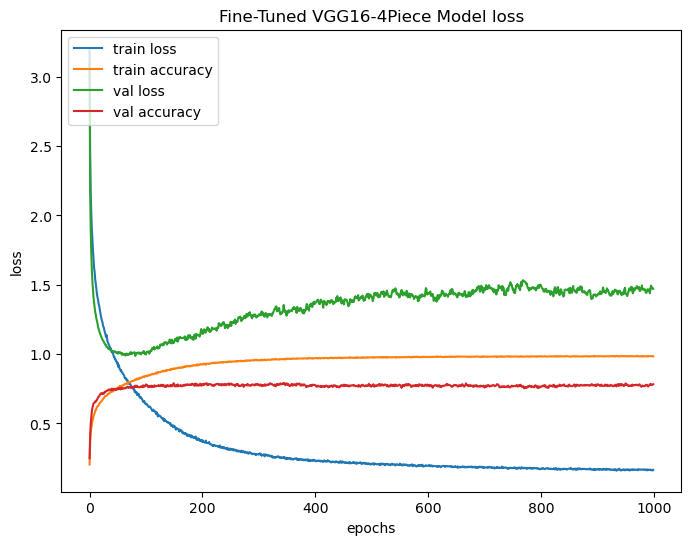

In [52]:
plot_train_loss(history, 'Fine-Tuned VGG16-4Piece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [53]:
train_preds = model1.predict(fine_tune_data_train)

 66/475 [===>..........................] - ETA: 0s

2022-10-08 18:38:03.917148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 1s 2ms/step


In [54]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [55]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [56]:
np.sum(train_pred_labels == train_labels['label'])

15197

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [57]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
9198,9682,./Data/train/train/9682.tif,12
12255,12896,./Data/train/train/12896.tif,9
14569,15333,./Data/train/train/15333.tif,7


In [58]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.997959,1.000000,0.998979,978
1,1.000000,1.000000,1.000000,925
2,1.000000,1.000000,1.000000,925
3,1.000000,1.000000,1.000000,947
4,0.998926,1.000000,0.999463,930
5,1.000000,1.000000,1.000000,962
6,1.000000,1.000000,1.000000,998
7,1.000000,0.998905,0.999452,913
8,1.000000,1.000000,1.000000,1005
9,1.000000,0.998951,0.999475,953


#### On Train-Test Data

In [59]:
test_preds = model1.predict(fine_tune_data_test)

25/25 [==============================] - 0s 3ms/step


In [60]:
test_pred_labels = np.argmax(test_preds, axis=-1)

In [61]:
test_pred_labels

array([11,  8,  6,  7,  1,  9, 13, 12, 14,  1,  6, 15,  0, 14,  1, 11,  0,
        6,  6, 12, 12, 14,  3, 12,  6,  0,  3, 12,  3,  3, 11,  1,  9,  2,
       13,  8,  4,  1, 11,  9,  6, 12, 14,  2,  5, 14,  7,  0, 13,  4,  0,
       10, 13, 15, 11, 14, 15,  9,  9,  2, 15, 13, 10, 11,  6,  8,  8,  0,
        6,  3,  4,  4, 12,  0,  8,  6,  7,  6, 12, 11, 11, 15, 12, 12,  9,
        8, 13, 13, 13, 13, 10, 11,  4, 10,  1,  7, 11,  8, 13, 10,  3, 10,
       12,  9,  1, 14,  8,  2,  5,  6,  7,  6,  9,  4, 12, 14, 12,  1, 11,
        6, 13,  1, 15, 10,  1, 10, 10,  8, 15, 10,  3, 11,  9,  1,  6,  9,
       14, 10,  7, 14, 10,  8,  4, 12,  8, 13,  8,  9,  2, 13,  0, 15,  4,
       14,  4,  9,  4, 14,  7,  7,  8,  4,  4, 11, 13,  8, 15,  3,  8,  8,
       13,  6,  3, 11,  7, 12, 10, 14, 14,  8,  6, 10, 13, 11,  6, 13,  4,
       14, 11,  7, 15,  0,  3,  0, 10, 13, 14, 10, 11, 11, 15, 11,  9,  1,
        9, 15, 13, 15, 12,  1,  4,  8,  7,  6,  1, 12,  4, 12,  8,  0,  9,
       13, 15, 15,  7,  7

In [62]:
np.sum(test_pred_labels == test_labels['label'])

614

In [63]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
7,100,./Data/train/train/100.tif,10
12,179,./Data/train/train/179.tif,7
17,353,./Data/train/train/353.tif,9
...,...,...,...
776,15528,./Data/train/train/15528.tif,5
779,15568,./Data/train/train/15568.tif,9
783,15589,./Data/train/train/15589.tif,5
785,15621,./Data/train/train/15621.tif,15


In [64]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.639344,0.722222,0.678261,54
1,0.560000,0.636364,0.595745,44
2,0.974359,0.883721,0.926829,43
3,0.914894,0.934783,0.924731,46
4,0.813953,0.972222,0.886076,36
5,0.846154,0.440000,0.578947,50
6,0.812500,0.847826,0.829787,46
7,0.860000,0.826923,0.843137,52
8,0.828125,0.981481,0.898305,54
9,0.840909,0.787234,0.813187,47


In [65]:
np.mean(fscore)

0.7672030719397613

#### On Validation Data

Generating Predictions for the Validation Set

In [66]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [67]:
fine_tune_data_validation = np.load('./Data/VGG16-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation.shape

(900, 5, 512)

In [68]:
valid_preds = model1.predict(fine_tune_data_validation)

29/29 [==============================] - 0s 3ms/step


2022-10-08 18:38:30.158487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [69]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

### Submission

For Kaggle Submission

In [70]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,4
1,17802,6
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,7
896,18697,12
897,18698,13
898,18699,12


In [71]:
submission_data.to_csv('./Submissions/submission-vgg16-4p.csv', index=False)